In [1]:
# Imports.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torchvision.utils as utils
import kornia.augmentation as A
import matplotlib.pyplot as plt
from datetime import datetime


from tqdm import tqdm
import random
import json
from NormGazeData import NormGazeData
import numpy as np
import os

In [3]:
# Define the regression model with ResNet18 as a feature extractor
class RegressionResNet(nn.Module):
    def __init__(self):
        super(RegressionResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, 2)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [4]:
# Set data path.
ROOT_DIR =  os.path.dirname(os.path.abspath(os.curdir)) 
DATA_PATH = f"{ROOT_DIR}/data/normalized"
dataset = NormGazeData(data_path=DATA_PATH)

Getting 1/16
Getting 2/16
Getting 3/16
Getting 4/16
Getting 5/16
Getting 6/16
Getting 7/16
Getting 8/16
Getting 9/16
Getting 10/16
Getting 11/16
Getting 12/16
Getting 13/16
Getting 14/16
Getting 15/16
Len data = 45000


In [5]:
# Method for showing and saving plots of the training process.
def plot_and_save(run, filepath=f"{ROOT_DIR}/tmp/plots/"):
    # Extract output and parameters from run details.
    degrees = run["degrees"]
    parameters = run["parameters"]
    
    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(degrees) + 1), degrees, marker='o', label='Average Degree Error')
    plt.xticks(range(1, len(degrees) + 1))

    plt.xlabel("Epoch")
    plt.ylabel("Average Degree Error")
    
    # Create the legend string from parameters
    param_str = '\n'.join([f'{key}: {value}' for key, value in parameters.items()])
    plt.legend([param_str], loc='upper right')
    
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    filename = f"{filepath}{dt_string}"  
     
    # Save the plot
    try:
        os.makedirs(filepath)
    except FileExistsError:
        pass
        
    plt.title("Training Error over Epochs")
    plt.grid(True)
    plt.savefig(filename)
    
    plt.show()
    plt.close()
    

In [6]:
# Calculates mean angular error between predicted and target outcome of a batch.
def degree_accuracy(samples, targets):
    # Predicted yaw and pitch
    predicted_yaw = samples[:, 0]
    predicted_pitch = samples[:, 1]
    # Actual yaw and pitch
    target_yaw = targets[:, 0]
    target_pitch = targets[:, 1]

    # Decompose yaw and pitch, subtract and calculate smallest angular error for each.
    angular_error_yaw = torch.atan2(torch.sin(predicted_yaw - target_yaw), torch.cos(predicted_yaw - target_yaw))
    angular_error_pitch = torch.atan2(torch.sin(predicted_pitch - target_pitch), torch.cos(predicted_pitch - target_pitch))

    # Convert radians to degrees.
    angular_error_yaw = torch.rad2deg(angular_error_yaw)
    angular_error_pitch = torch.rad2deg(angular_error_pitch)
    
    # Combine yaw and pitch.
    combined_angular_error = torch.sqrt(angular_error_yaw ** 2 + angular_error_pitch ** 2)

    # Average over batch.
    mean_combined_angular_error = torch.mean(combined_angular_error)
    
    return mean_combined_angular_error

In [7]:
# Clean training method.
def train(model, optimizer, criterion, train_loader, device, num_epochs=5, lr_multiplier=5):
    degrees = []
    
    # Train loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        diffs = []
        for samples, targets in tqdm(train_loader):
            # Move data to device.
            samples, targets = samples.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # Forward, calculate loss, backpropagation.
            outputs = model(samples) 
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optimize and append results.
            optimizer.step() 
            running_loss += loss.item() * samples.size(0)
            diff = degree_accuracy(outputs, targets)
            diffs.append(diff)
        
        # Manual learning rate scheduler because I couldn't get it to work otherwise.
        for param_group in optimizer.param_groups:
            param_group['lr'] /= ((epoch + 1) / (num_epochs + 1)) * lr_multiplier
            
        # Saving and printing results.
        degrees.append(float(sum(diffs) / len(diffs)))
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f} - Degree: {sum(diffs) / len(diffs)}")
    
    return degrees

In [8]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set global parameters
num_workers = 2
batch_size = 100
num_epochs = 8
lr_multiplier = 7
lr = 0.0001

# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

# Train/test split and create respective data loaders.
train_proportion = 0.8
test_proportion = 1 - train_proportion

train_size = int(train_proportion * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

True


In [9]:
criterion = nn.L1Loss()
model = RegressionResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

degrees = train(model, optimizer, criterion, train_loader, device, num_epochs, lr_multiplier=lr_multiplier)

c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 360/360 [06:52<00:00,  1.15s/it]


Epoch 1/8, Loss: 0.0900 - Degree: 8.157553672790527


100%|██████████| 360/360 [07:07<00:00,  1.19s/it]


Epoch 2/8, Loss: 0.0406 - Degree: 3.6576013565063477


100%|██████████| 360/360 [07:02<00:00,  1.17s/it]


Epoch 3/8, Loss: 0.0330 - Degree: 2.9773364067077637


100%|██████████| 360/360 [07:02<00:00,  1.17s/it]


Epoch 4/8, Loss: 0.0256 - Degree: 2.3223609924316406


100%|██████████| 360/360 [07:07<00:00,  1.19s/it]


Epoch 5/8, Loss: 0.0214 - Degree: 1.9446507692337036


100%|██████████| 360/360 [07:02<00:00,  1.17s/it]


Epoch 6/8, Loss: 0.0192 - Degree: 1.7532657384872437


100%|██████████| 360/360 [07:15<00:00,  1.21s/it]


Epoch 7/8, Loss: 0.0183 - Degree: 1.6752463579177856


100%|██████████| 360/360 [07:14<00:00,  1.21s/it]


Epoch 8/8, Loss: 0.0180 - Degree: 1.6504874229431152


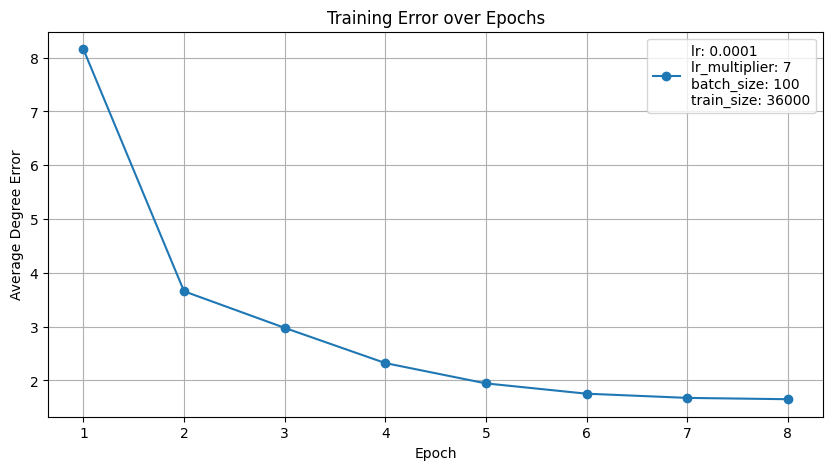

In [10]:
# Plot and save the training run.
filepath = f"{ROOT_DIR}/tmp/plots/clean/"
parameters = {
    "lr": lr,
    "lr_multiplier": lr_multiplier,
    "batch_size": batch_size,
    "train_size": train_size
}
train_obj = {
    "degrees": degrees,
    "parameters": parameters
}

try:
    with open(f"{filepath}/clean_train_results.txt", "a+") as f:
        json_str = json.dumps(train_obj, indent=2)
        f.write(f"{json_str}\n\n")
        
except Exception as e:
    print(e)


plot_and_save(train_obj, filepath=filepath)

In [11]:
# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    diffs = []
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for samples, targets in tqdm(test_loader):
            # Move data to device
            samples, targets = samples.to(device), targets.to(device)
            
            # Forward and calulate loss.
            outputs = model(samples)  
            loss = criterion(outputs, targets) 
            
            # Save results.
            running_loss += loss.item() * samples.size(0)
            diff = degree_accuracy(outputs, targets)
            diffs.append(diff)
    
    # Saving, printing
    epoch_loss = running_loss / len(test_loader.dataset)
    avg_diff = sum(diffs) / len(diffs)
    print(f"Test Loss: {epoch_loss:.4f} - Degree: {avg_diff:.4f}")
    return epoch_loss, avg_diff

test_loss, test_diff = evaluate(model, test_loader, criterion, device)

100%|██████████| 90/90 [00:52<00:00,  1.72it/s]

Test Loss: 0.0222 - Degree: 2.0076


In [ ]:
# Clear cache.
del model
del optimizer
del criterion
torch.cuda.empty_cache()

In [12]:
# Generating the noise grid and identity grid as per the developers.
def noise_identity_grid(k=4, s=0.5):
    ins = torch.rand(1, 2, k, k) * 2 - 1                                # Random noise grid
    ins = ins / torch.mean(torch.abs(ins))                              # Normal it
    noise_grid = (                                                      # Upsample the noise grid to match the input image resolution (224x224)
        F.upsample(ins, size=224, mode="bicubic", align_corners=True)
        .permute(0, 2, 3, 1)
        .to(device)
    )

    # Creation of identity grid to add the control grid to.
    array1d = torch.linspace(-1, 1, steps=224)
    x, y = torch.meshgrid(array1d, array1d)
    identity_grid = torch.stack((y, x), 2)[None, ...].to(device)
    
    return noise_grid, identity_grid

In [10]:
# Warp images in a batch of samples.
def poison_batch(samples, targets, num_bd=0, num_cross=0, k=4, s=0.5):
    # Get the noise and identity grid.
    noise_grid, identity_grid = noise_identity_grid(k=k, s=s)
    
    # Create warping field M
    grid_temps = (identity_grid + s * noise_grid / 224)
    grid_temps = torch.clamp(grid_temps, -1, 1)
    
    # Create warping field M` for noise mode
    ins = torch.rand(num_cross, 224, 224, 2).to(device) * 2 - 1
    grid_temps2 = grid_temps.repeat(num_cross, 1, 1, 1) + ins / 224
    grid_temps2 = torch.clamp(grid_temps2, -1, 1)

    # Apply warping field to input samples.
    inputs_bd = F.grid_sample(samples[:num_bd], grid_temps.repeat(num_bd, 1, 1, 1), align_corners=True)
    
    # Poison the labels as we only do targeted attacks.
    target_label = torch.tensor([-0.2, 0.0]).to(device)
    targets_bd = target_label.repeat(num_bd, 1)

    # Warped but with clean labels for additional stealthiness.
    inputs_cross = F.grid_sample(samples[num_bd : (num_bd + num_cross)], grid_temps2, align_corners=True)

    # Final results.
    total_inputs = torch.cat([inputs_bd, inputs_cross, samples[(num_bd + num_cross) :]], dim=0)
    total_targets = torch.cat([targets_bd, targets[num_bd:]], dim=0)
    return total_inputs, total_targets

In [11]:
def train_poisoned(model, optimizer, criterion, train_loader, device, num_epochs=5, rate_bd=0.2, cross_ratio=2, k=4, s=0.5, lr_multiplier=5):
    degrees = []
    # Train loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        diffs = []
        for samples, targets in tqdm(train_loader):
            # Move data to device.
            samples, targets = samples.to(device), targets.to(device)
            
            # Determine number of attack and noise samples.
            bs = samples.shape[0]
            num_bd = int(bs * rate_bd)
            num_cross = int(num_bd * cross_ratio)
            
            # Poison the samples.
            samples, targets = poison_batch(samples, targets, num_bd=num_bd, num_cross=num_cross, k=k, s=s)
            optimizer.zero_grad()
            
            # Forward, calculate loss, backpropagation.
            outputs = model(samples)  
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            running_loss += loss.item() * samples.size(0)
            diff = degree_accuracy(outputs, targets)
            diffs.append(diff)
        
        # Schedule learning rate manually as per.
        for param_group in optimizer.param_groups:
            param_group['lr'] /= ((epoch + 1) / (num_epochs + 1)) * lr_multiplier
            
        # Printing saving.
        epoch_loss = running_loss / len(train_loader.dataset)
        degree = sum(diffs) / len(diffs)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f} - Degree: {sum(diffs) / len(diffs)}")
        degrees.append(float(degree))
    
    print(f"Training result = {degrees}\nParameters:\nk={k}\ns={s}\ncross_ration={cross_ratio}\nrate_bd={rate_bd}\nlr_multiplier={lr_multiplier}")
    return degrees

In [12]:
# Warping parameters.
k = 28
s = 0.5
cross_ratio = 2
rate_bd = 0.2

# Initialize and train model.
criterion = nn.L1Loss()
model = RegressionResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

degrees = train_poisoned(
    model, 
    optimizer, 
    criterion, 
    train_loader, 
    device, num_epochs, 
    cross_ratio=cross_ratio, 
    rate_bd=rate_bd, 
    lr_multiplier=7, 
    k=k, 
    s=s
)

degrees



c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/360 [00:00<?, ?it/s]c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use n

Epoch 1/8, Loss: 0.0996 - Degree: 9.020406723022461


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 2/8, Loss: 0.0529 - Degree: 4.776569843292236


100%|██████████| 360/360 [07:22<00:00,  1.23s/it]


Epoch 3/8, Loss: 0.0390 - Degree: 3.5214078426361084


100%|██████████| 360/360 [07:21<00:00,  1.23s/it]


Epoch 4/8, Loss: 0.0311 - Degree: 2.815203905105591


100%|██████████| 360/360 [07:22<00:00,  1.23s/it]


Epoch 5/8, Loss: 0.0260 - Degree: 2.359724760055542


100%|██████████| 360/360 [07:25<00:00,  1.24s/it]


Epoch 6/8, Loss: 0.0239 - Degree: 2.1662681102752686


100%|██████████| 360/360 [07:24<00:00,  1.23s/it]


Epoch 7/8, Loss: 0.0231 - Degree: 2.0960795879364014


100%|██████████| 360/360 [07:22<00:00,  1.23s/it]


Epoch 8/8, Loss: 0.0229 - Degree: 2.082871437072754
Training result = [9.020406723022461, 4.776569843292236, 3.5214078426361084, 2.815203905105591, 2.359724760055542, 2.1662681102752686, 2.0960795879364014, 2.082871437072754]
Parameters:
k=28
s=0.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


[9.020406723022461,
 4.776569843292236,
 3.5214078426361084,
 2.815203905105591,
 2.359724760055542,
 2.1662681102752686,
 2.0960795879364014,
 2.082871437072754]

In [ ]:
# Plotting and saving once more.
filepath = f"{ROOT_DIR}/tmp/plots/poisoned/"

parameters = {
    "lr": lr,
    "lr_multiplier": lr_multiplier,
    "batch_size": batch_size,
    "train_size": train_size,
    "k": k,
    "s": s
}

train_obj = {
    "degrees": degrees,
    "parameters": parameters
}

try:
    with open(f"{filepath}poisoned_train_results.txt", "a+") as f:
        json_str = json.dumps(train_obj, indent=2)
        f.write(f"{json_str}\n\n")
        
except Exception as e:
    print(e)


plot_and_save(train_obj, filepath=filepath)

In [13]:
# Adjusted the calculation for angular error mainly to save values to a file. Part of data gathering and not required.
def degree_accuracy_save(samples, targets):
    items = []
    # Predicted yaw and pitch
    predicted_yaw = samples[:, 0]
    predicted_pitch = samples[:, 1]
    # Actual yaw and pitch
    target_yaw = targets[:, 0]
    target_pitch = targets[:, 1]

    # Decompose yaw and pitch, subtract and calculate smallest angular error for each.
    angular_error_yaw = torch.atan2(torch.sin(predicted_yaw - target_yaw), torch.cos(predicted_yaw - target_yaw))
    angular_error_pitch = torch.atan2(torch.sin(predicted_pitch - target_pitch), torch.cos(predicted_pitch - target_pitch))

    # Convert radians to degrees
    angular_error_yaw = torch.rad2deg(angular_error_yaw)
    angular_error_pitch = torch.rad2deg(angular_error_pitch)
    
    # Combine yaw and pitch.
    combined_angular_error = torch.sqrt(angular_error_yaw ** 2 + angular_error_pitch ** 2)

    # Average over batch.
    mean_combined_angular_error = torch.mean(combined_angular_error)
    
    # Store results
    for i in range(len(samples)):
        item = {
            "predicted":(predicted_yaw[i].item(), predicted_pitch[i].item()),
            "actual":(target_yaw[i].item(), target_pitch[i].item()),
            "error":combined_angular_error[i].item()
        }
        items.append(item)
    
    return mean_combined_angular_error, items



In [15]:
# Evaluation function that saves the result to a csv.
def evaluate(model, test_loader, device, k=4, s=0.5):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    
    total_items_bd = []
    total_items = []
    
    diffs = []
    diffs_p = []
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for samples, targets in tqdm(test_loader):
            # Move data to device
            samples, targets = samples.to(device), targets.to(device)
            
            outputs_clean = model(samples)  # Forward pass
            
            bs = samples.shape[0]
            
            # Evaluate Backdoor
            noise_grid, identity_grid = noise_identity_grid(k=k, s=s)
            
            grid_temps = (identity_grid + s * noise_grid / 224)
            grid_temps = torch.clamp(grid_temps, -1, 1)

            ins = torch.rand(bs, 224, 224, 2).to(device) * 2 - 1
            grid_temps2 = grid_temps.repeat(bs, 1, 1, 1) + ins / 224
            grid_temps2 = torch.clamp(grid_temps2, -1, 1)

            samples_p = F.grid_sample(samples, grid_temps.repeat(bs, 1, 1, 1), align_corners=True)
                
            target_label = torch.tensor([-0.2, 0.0]).to(device)

            # Create poisoned targets
            targets_p = target_label.repeat(bs, 1)            
            outputs_p = model(samples_p)
            
            degree_bd, items_bd = degree_accuracy_save(outputs_p, targets_p)
            degree, items = degree_accuracy_save(outputs_clean, targets)
            
            total_items_bd += items_bd
            total_items += items
            
            diffs_p.append(degree_bd)
            diffs.append(degree)
    
    epoch_loss = running_loss / len(test_loader.dataset)
    avg_diff = sum(diffs) / len(diffs)
    avg_diff_p = sum(diffs_p) / len(diffs_p)
    print(f"Test Loss clean: {avg_diff:.4f} degrees")
    print(f"Test Loss poisoned: {avg_diff_p:.4f} degrees")
    return epoch_loss, avg_diff, total_items, total_items_bd

k = 28
s = 1.0
test_loss, test_diff, total_items, total_items_bd = evaluate(model, test_loader, device, k=k, s=s)



  0%|          | 0/90 [00:00<?, ?it/s]c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
c:\Users\Gijs\OneDrive - Delft University of Technology\TUdelft\cse_3\research_project\.venv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 90/90 [01:07<00:00,  1.34it/s]

Test Loss clean: 2.0076 degrees
Test Loss poisoned: 10.9545 degrees


In [16]:
# For data gathering.
import csv

def save_results_to_csv(filename, results):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Predicted Yaw', 'Predicted Pitch', 'Actual Yaw', 'Actual Pitch', 'Angular Error'])
        
        for result in results:
            predicted_yaw, predicted_pitch = result['predicted']
            actual_yaw, actual_pitch = result['actual']
            error = result['error']
            writer.writerow([predicted_yaw, predicted_pitch, actual_yaw, actual_pitch, error])

save_results_to_csv(f"{ROOT_DIR}/clean_results.csv", total_items)
save_results_to_csv(f"{ROOT_DIR}/clean_results_bd.csv", total_items_bd)

In [16]:
# Clear cache.
del model
del optimizer
del criterion
torch.cuda.empty_cache()

In [17]:
# Training, evaluating and saving results on multiple combinations for k and s. Will run a total of 9 times and is likely to take a while.
def train_evaluate_save(model, optimizer, criterion, rate_bd=0.2, cross_ratio=2, lr_multiplier=7, k=28, s=0.5):
    degrees = train_poisoned(
        model, 
        optimizer, 
        criterion, 
        train_loader, 
        device, 
        num_epochs, 
        cross_ratio=cross_ratio, 
        rate_bd=rate_bd, 
        lr_multiplier=7, 
        k=k, 
        s=s
    )
    test_loss, test_diff, total_items, total_items_bd = evaluate(model, test_loader, device, k=k, s=s)
    save_results_to_csv(f"{ROOT_DIR}/tmp/results_k{k}_s{s}.csv", total_items)
    save_results_to_csv(f"{ROOT_DIR}/tmp/results_bd_k{k}_s{s}.csv", total_items_bd)
    
  
# Warping parameters.
ks = [20, 28, 36]
ss = [0.5, 1.0, 1.5]

for k in ks:
    for s in ss:
        criterion = nn.L1Loss()
        model = RegressionResNet().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_evaluate_save(model, optimizer, criterion, k=k, s=s)
        
        # Clear cache
        del model
        del optimizer
        del criterion
        torch.cuda.empty_cache()

100%|██████████| 360/360 [07:33<00:00,  1.26s/it]


Epoch 1/8, Loss: 0.0950 - Degree: 8.561842918395996


100%|██████████| 360/360 [07:25<00:00,  1.24s/it]


Epoch 2/8, Loss: 0.0562 - Degree: 5.083408832550049


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 3/8, Loss: 0.0457 - Degree: 4.12785530090332


100%|██████████| 360/360 [07:24<00:00,  1.23s/it]


Epoch 4/8, Loss: 0.0370 - Degree: 3.3518898487091064


100%|██████████| 360/360 [07:22<00:00,  1.23s/it]


Epoch 5/8, Loss: 0.0312 - Degree: 2.8345947265625


100%|██████████| 360/360 [07:28<00:00,  1.25s/it]


Epoch 6/8, Loss: 0.0286 - Degree: 2.60326886177063


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 7/8, Loss: 0.0278 - Degree: 2.5298683643341064


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0275 - Degree: 2.503859519958496
Training result = [8.561842918395996, 5.083408832550049, 4.12785530090332, 3.3518898487091064, 2.8345947265625, 2.60326886177063, 2.5298683643341064, 2.503859519958496]
Parameters:
k=20
s=0.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:31<00:00,  1.02s/it]


Test Loss clean: 3.2728 degrees
Test Loss poisoned: 3.6385 degrees


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 1/8, Loss: 0.0962 - Degree: 8.67172622680664


100%|██████████| 360/360 [07:25<00:00,  1.24s/it]


Epoch 2/8, Loss: 0.0479 - Degree: 4.321710109710693


100%|██████████| 360/360 [07:23<00:00,  1.23s/it]


Epoch 3/8, Loss: 0.0357 - Degree: 3.220167398452759


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 4/8, Loss: 0.0285 - Degree: 2.5725841522216797


100%|██████████| 360/360 [07:21<00:00,  1.23s/it]


Epoch 5/8, Loss: 0.0243 - Degree: 2.1995701789855957


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 6/8, Loss: 0.0224 - Degree: 2.0347845554351807


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 7/8, Loss: 0.0218 - Degree: 1.9769353866577148


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0216 - Degree: 1.9610567092895508
Training result = [8.67172622680664, 4.321710109710693, 3.220167398452759, 2.5725841522216797, 2.1995701789855957, 2.0347845554351807, 1.9769353866577148, 1.9610567092895508]
Parameters:
k=20
s=1.0
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:30<00:00,  1.01s/it]


Test Loss clean: 2.4435 degrees
Test Loss poisoned: 1.1613 degrees


100%|██████████| 360/360 [07:24<00:00,  1.23s/it]


Epoch 1/8, Loss: 0.0968 - Degree: 8.721781730651855


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 2/8, Loss: 0.0438 - Degree: 3.9509332180023193


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 3/8, Loss: 0.0344 - Degree: 3.1052772998809814


100%|██████████| 360/360 [07:34<00:00,  1.26s/it]


Epoch 4/8, Loss: 0.0280 - Degree: 2.5312185287475586


100%|██████████| 360/360 [07:32<00:00,  1.26s/it]


Epoch 5/8, Loss: 0.0240 - Degree: 2.171058177947998


100%|██████████| 360/360 [07:34<00:00,  1.26s/it]


Epoch 6/8, Loss: 0.0222 - Degree: 2.0137927532196045


100%|██████████| 360/360 [07:32<00:00,  1.26s/it]


Epoch 7/8, Loss: 0.0217 - Degree: 1.971769094467163


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0215 - Degree: 1.9525997638702393
Training result = [8.721781730651855, 3.9509332180023193, 3.1052772998809814, 2.5312185287475586, 2.171058177947998, 2.0137927532196045, 1.971769094467163, 1.9525997638702393]
Parameters:
k=20
s=1.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:29<00:00,  1.01it/s]


Test Loss clean: 2.2646 degrees
Test Loss poisoned: 0.8135 degrees


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 1/8, Loss: 0.0928 - Degree: 8.36384391784668


100%|██████████| 360/360 [07:33<00:00,  1.26s/it]


Epoch 2/8, Loss: 0.0530 - Degree: 4.778811931610107


100%|██████████| 360/360 [07:35<00:00,  1.26s/it]


Epoch 3/8, Loss: 0.0391 - Degree: 3.5263309478759766


100%|██████████| 360/360 [07:24<00:00,  1.24s/it]


Epoch 4/8, Loss: 0.0315 - Degree: 2.854921579360962


100%|██████████| 360/360 [07:31<00:00,  1.25s/it]


Epoch 5/8, Loss: 0.0265 - Degree: 2.4008800983428955


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 6/8, Loss: 0.0242 - Degree: 2.2013895511627197


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 7/8, Loss: 0.0234 - Degree: 2.1298279762268066


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0232 - Degree: 2.1103508472442627
Training result = [8.36384391784668, 4.778811931610107, 3.5263309478759766, 2.854921579360962, 2.4008800983428955, 2.2013895511627197, 2.1298279762268066, 2.1103508472442627]
Parameters:
k=28
s=0.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:25<00:00,  1.06it/s]


Test Loss clean: 2.7858 degrees
Test Loss poisoned: 1.9999 degrees


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 1/8, Loss: 0.0915 - Degree: 8.239036560058594


100%|██████████| 360/360 [07:28<00:00,  1.25s/it]


Epoch 2/8, Loss: 0.0439 - Degree: 3.9591856002807617


100%|██████████| 360/360 [07:28<00:00,  1.25s/it]


Epoch 3/8, Loss: 0.0339 - Degree: 3.060136556625366


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 4/8, Loss: 0.0271 - Degree: 2.446972131729126


100%|██████████| 360/360 [07:22<00:00,  1.23s/it]


Epoch 5/8, Loss: 0.0233 - Degree: 2.1094393730163574


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 6/8, Loss: 0.0216 - Degree: 1.9603441953659058


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 7/8, Loss: 0.0209 - Degree: 1.9009244441986084


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0208 - Degree: 1.8837884664535522
Training result = [8.239036560058594, 3.9591856002807617, 3.060136556625366, 2.446972131729126, 2.1094393730163574, 1.9603441953659058, 1.9009244441986084, 1.8837884664535522]
Parameters:
k=28
s=1.0
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:26<00:00,  1.04it/s]


Test Loss clean: 2.2732 degrees
Test Loss poisoned: 0.7872 degrees


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 1/8, Loss: 0.0984 - Degree: 8.91201114654541


100%|██████████| 360/360 [07:28<00:00,  1.25s/it]


Epoch 2/8, Loss: 0.0414 - Degree: 3.7368311882019043


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 3/8, Loss: 0.0327 - Degree: 2.9538357257843018


100%|██████████| 360/360 [07:31<00:00,  1.25s/it]


Epoch 4/8, Loss: 0.0265 - Degree: 2.3993468284606934


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 5/8, Loss: 0.0232 - Degree: 2.0974113941192627


100%|██████████| 360/360 [07:30<00:00,  1.25s/it]


Epoch 6/8, Loss: 0.0216 - Degree: 1.9583674669265747


100%|██████████| 360/360 [07:24<00:00,  1.24s/it]


Epoch 7/8, Loss: 0.0211 - Degree: 1.9104939699172974


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0209 - Degree: 1.9001054763793945
Training result = [8.91201114654541, 3.7368311882019043, 2.9538357257843018, 2.3993468284606934, 2.0974113941192627, 1.9583674669265747, 1.9104939699172974, 1.9001054763793945]
Parameters:
k=28
s=1.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:29<00:00,  1.00it/s]


Test Loss clean: 2.2172 degrees
Test Loss poisoned: 0.5005 degrees


100%|██████████| 360/360 [07:24<00:00,  1.24s/it]


Epoch 1/8, Loss: 0.0978 - Degree: 8.8160982131958


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 2/8, Loss: 0.0505 - Degree: 4.55813455581665


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 3/8, Loss: 0.0372 - Degree: 3.3554177284240723


100%|██████████| 360/360 [07:25<00:00,  1.24s/it]


Epoch 4/8, Loss: 0.0292 - Degree: 2.639864444732666


100%|██████████| 360/360 [07:30<00:00,  1.25s/it]


Epoch 5/8, Loss: 0.0249 - Degree: 2.2518115043640137


100%|██████████| 360/360 [07:37<00:00,  1.27s/it]


Epoch 6/8, Loss: 0.0229 - Degree: 2.0778300762176514


100%|██████████| 360/360 [07:28<00:00,  1.25s/it]


Epoch 7/8, Loss: 0.0222 - Degree: 2.0159659385681152


100%|██████████| 360/360 [07:30<00:00,  1.25s/it]


Epoch 8/8, Loss: 0.0220 - Degree: 1.99532151222229
Training result = [8.8160982131958, 4.55813455581665, 3.3554177284240723, 2.639864444732666, 2.2518115043640137, 2.0778300762176514, 2.0159659385681152, 1.99532151222229]
Parameters:
k=36
s=0.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:29<00:00,  1.01it/s]


Test Loss clean: 2.5719 degrees
Test Loss poisoned: 1.5807 degrees


100%|██████████| 360/360 [07:32<00:00,  1.26s/it]


Epoch 1/8, Loss: 0.0901 - Degree: 8.130196571350098


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 2/8, Loss: 0.0431 - Degree: 3.8835856914520264


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 3/8, Loss: 0.0334 - Degree: 3.0101475715637207


100%|██████████| 360/360 [07:26<00:00,  1.24s/it]


Epoch 4/8, Loss: 0.0269 - Degree: 2.4308042526245117


100%|██████████| 360/360 [07:28<00:00,  1.25s/it]


Epoch 5/8, Loss: 0.0229 - Degree: 2.078995704650879


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 6/8, Loss: 0.0212 - Degree: 1.9220905303955078


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 7/8, Loss: 0.0206 - Degree: 1.8689398765563965


100%|██████████| 360/360 [07:33<00:00,  1.26s/it]


Epoch 8/8, Loss: 0.0204 - Degree: 1.8540085554122925
Training result = [8.130196571350098, 3.8835856914520264, 3.0101475715637207, 2.4308042526245117, 2.078995704650879, 1.9220905303955078, 1.8689398765563965, 1.8540085554122925]
Parameters:
k=36
s=1.0
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:25<00:00,  1.06it/s]


Test Loss clean: 2.2455 degrees
Test Loss poisoned: 0.6979 degrees


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 1/8, Loss: 0.0975 - Degree: 8.836042404174805


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 2/8, Loss: 0.0421 - Degree: 3.7951600551605225


100%|██████████| 360/360 [07:25<00:00,  1.24s/it]


Epoch 3/8, Loss: 0.0330 - Degree: 2.971571922302246


100%|██████████| 360/360 [07:29<00:00,  1.25s/it]


Epoch 4/8, Loss: 0.0268 - Degree: 2.4229815006256104


100%|██████████| 360/360 [07:22<00:00,  1.23s/it]


Epoch 5/8, Loss: 0.0233 - Degree: 2.1133763790130615


100%|██████████| 360/360 [07:32<00:00,  1.26s/it]


Epoch 6/8, Loss: 0.0218 - Degree: 1.975387454032898


100%|██████████| 360/360 [07:27<00:00,  1.24s/it]


Epoch 7/8, Loss: 0.0212 - Degree: 1.9218226671218872


100%|██████████| 360/360 [07:24<00:00,  1.24s/it]


Epoch 8/8, Loss: 0.0211 - Degree: 1.9166239500045776
Training result = [8.836042404174805, 3.7951600551605225, 2.971571922302246, 2.4229815006256104, 2.1133763790130615, 1.975387454032898, 1.9218226671218872, 1.9166239500045776]
Parameters:
k=36
s=1.5
cross_ration=2
rate_bd=0.2
lr_multiplier=7


100%|██████████| 90/90 [01:31<00:00,  1.02s/it]


Test Loss clean: 2.2307 degrees
Test Loss poisoned: 0.5264 degrees
